code based on: https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb

In [1]:
# Data Structures
import numpy  as np
import pandas as pd
import json

# Corpus Processing
import re
import nltk.corpus
from nltk import punkt
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score


In [2]:
filepath = 'resources\\DATA_CLEAN.csv'
data = pd.read_csv(filepath)
data.head()

,Unnamed: 0,User,Text,Date,Favorites,Retweets,Mentions,Hashtags
0,0,Emill1984,"Ciekawe czasy nastaly, ze atak #koronawirus.a ...",2020-01-30 23:59:58+00:00,0,13,NaN,#koronawirus
1,1,DawidParzyk,Robot o nazwie Little Peanut dostarcza żywność...,2020-01-30 23:58:16+00:00,2,0,NaN,#koronawirus #wirus #chiny #wuhan #technologia...
2,2,SamPereira_,Marszałek Grodzki o Polsce: W Brukseli boją si...,2020-01-30 23:55:13+00:00,10,27,NaN,NaN
3,3,mk1977_ewa,Koronawirus i lukrecja - odpowiadam hejterom h...,2020-01-30 23:51:40+00:00,0,0,@YouTube,NaN
4,4,MediaNarodoweMN,"Podaj dalej, dziękujemy 👍 Czy #koronawirus jes...",2020-01-30 23:50:45+00:00,13,20,NaN,#koronawirus


In [21]:
corpus = data.Text.tolist()
corpus[:10]

['Ciekawe czasy nastaly, ze atak #koronawirus.a pomogl rozpromowac na nowo gre, ktora ma juz 8 lat na karku ;) ',
 'Robot o nazwie Little Peanut dostarcza żywność osobom poddanym kwarantannie po podróży samolotem z pacjentami podejrzanymi o zarażenie koronawirusem Wuhan. Źródło: https://twitter.com/XHNews/status/1221782244525858819 #koronawirus #wirus #chiny #wuhan #technologia #robot #innowacja',
 'Marszałek Grodzki o Polsce: W Brukseli boją się że ten koronawirus zacznie się rozszerzać ',
 'Koronawirus i lukrecja - odpowiadam hejterom https://youtu.be/YwYbsVytL-8 przez @YouTube',
 'Podaj dalej, dziękujemy 👍 Czy #koronawirus jest realnym zagrożeniem ❓❓❓ ➡ https://youtu.be/NfGT0i9Yceo Specjalnie dla Mediów Narodowych wypowiedziała się pani ekspert w dziedzinie wirusologi ☢',
 'Zwierzęta domowe są zagrożone #koronawirus, ale nie nowym #nCoV19 a zwyklym, dotychczasowo występującym i nie przenoszą go na ludzi. To dobra wiadomość dla wszystkich psiarzy i kociarzy. #coronavirus',
 'Relacja 

In [4]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [5]:
def processCorpus(corpus, language):   
    param_stemmer = SnowballStemmer(language)
    with open('resources\\stopwords_all.txt', 'r', encoding="utf-8") as f:
            stopwords = [line.strip() for line in f]
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        #corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)
        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        
        lemmatizer = WordNetLemmatizer()
        listOfTokens = [lemmatizer.lemmatize(word) for word in listOfTokens]

        corpus[index]   = " ".join(listOfTokens)

    return corpus

In [17]:
language = 'porter' #Porter algiritm as Polish language is not supported by nltk SnowballStemmer
corpus = processCorpus(corpus, language)
corpus[0][0:460]

'ciekawe czasy nastaly atak koronawirus.a pomogl rozpromowac nowo gre ktora juz lat karku'

Statistical weighting of words

In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

4215 rows


,0,1,2,3,4,5,6,7,8,9,...,4205,4206,4207,4208,4209,4210,4211,4212,4213,4214
gre,0.321266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
karku,0.321266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nastaly,0.321266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pomogl,0.321266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rozpromowac,0.321266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# K-means

In [8]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [9]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [10]:
# Running Kmeans
k = 7
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
#silhouette(kmeans_results, final_df, plot=True)

In [11]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

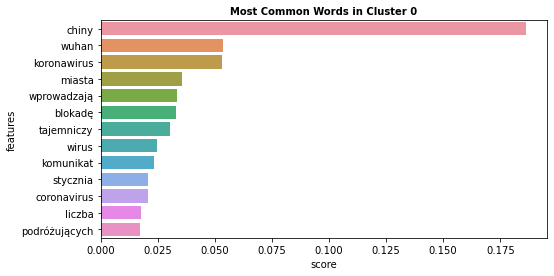

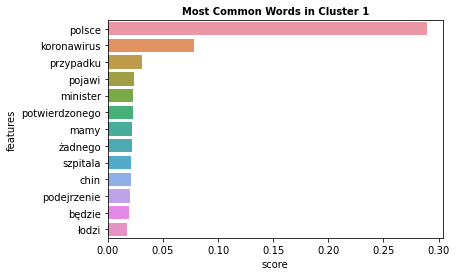

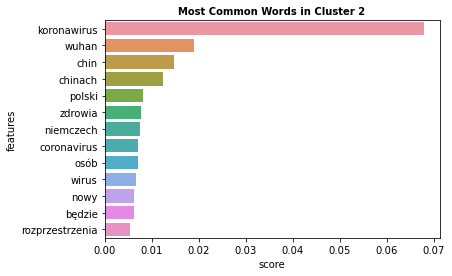

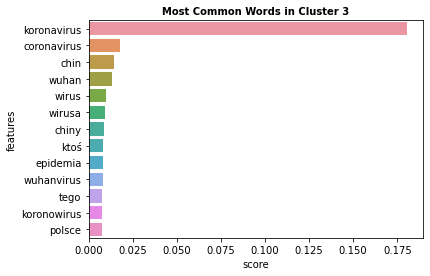

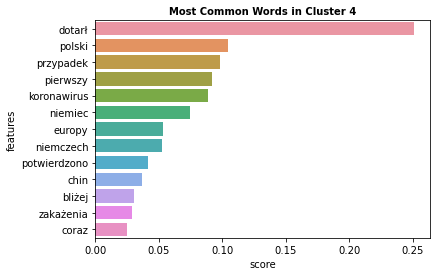

In [12]:
best_result = 5
kmeans = kmeans_results.get(best_result)
final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)